# ClickDetector use example
This algorithm computes the SNR of the input audio in a frame-wise manner.
The algorithm assumes that:
- 1. The noise is gaussian.
- 2. There is a region of noise (without signal) at the beginning of the stream in order to estimate the PSD of the noise.[1]
    
Once the noise PSD is estimated, the algorithm relies on the Ephraim-Malah [2] recursion to estimate the SNR for each frequency bin. The algorithm also returns an overall (a single value for the whole spectrum)
SNR estimation and an averaged overall SNR estimation using Exponential Moving Average filtering.
This algorithm throws a Warning if less than 15 frames are used to estimte the noise PSD.
  
      References:
        [1] Vaseghi, S. V. (2008). Advanced digital signal processing and noise reduction. John Wiley & Sons. Page 336.
        [2] Ephraim, Y., & Malah, D. (1984). Speech enhancement using a minimum-mean square error short-time spectral amplitude estimator. IEEE Transactions on acoustics, speech, and signal processing, 32(6), 1109-1121.

In [73]:
import essentia.standard as es
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio 
from essentia import array as esarr
from essentia import instantPower
from essentia import db2amp

plt.rcParams["figure.figsize"] =(12,9)
eps = np.finfo(np.float32).eps

In [72]:
def compute(x, frame_size=1024, hop_size=512, **kwargs):
    snr = es.SNR(frameSize=frame_size,
                 **kwargs)
    instantSNR_vector = []
    spectralSNR_vector = []
    for frame in es.FrameGenerator(x, frameSize=frame_size,
                                   hopSize=hop_size, startFromZero=True):
        instantSNR, averagedSNR, spectralSNR = snr(frame)
        
        instantSNR_vector.append(instantSNR)
        spectralSNR_vector.append(spectralSNR)
        
    return esarr(instantSNR_vector), averagedSNR, esarr(spectralSNR_vector).T

# A basic example

Lets start by creating a simple sinusoid plus white gaussian noise representing the signal and the noise pars.

Sigal level: -25.01dB
Noise level: -50.00dB
SNR: 24.99dB


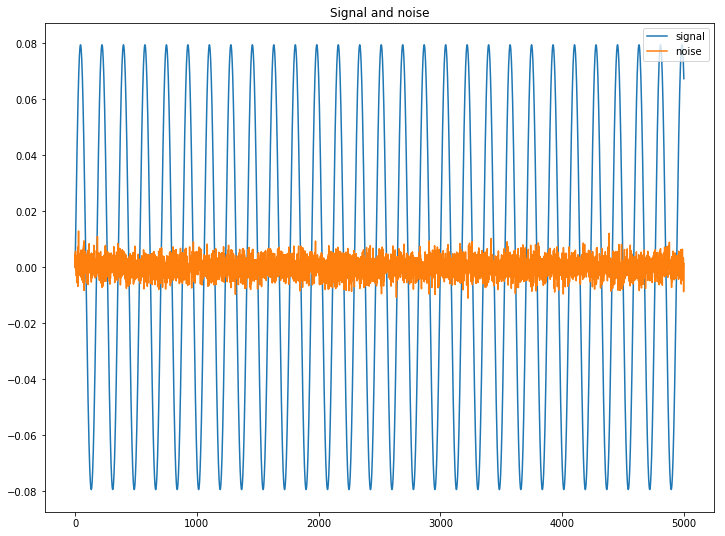

In [40]:
fs = 44100.
time = 5.  # s
signal_db = -22.
signal_freq = 250.
noise_db  = -50.
nise_only = 1

frameSize = 512

time_axis = np.arange(0, time, 1 / fs)
nsamples = len(time_axis)

noise = np.random.randn(nsamples)
noise /= np.std(noise)
noise *= db2amp(noise_db)


signal = np.sin(2 * np.pi * signal_freq * time_axis)
signal *= db2amp(signal_db)


signal_iP = instantPower(signal[int(noise_only * fs):].astype(np.float32))

noise_iP = instantPower(noise[int(noise_only * fs):].astype(np.float32))

snr_gt = 10. * np.log10( signal_iP / noise_iP )


plt.plot(signal[:5000], label='signal')
plt.plot(noise[:5000], label='noise')
plt.title('Signal and noise')
plt.legend()
print 'Sigal level: {:.2f}dB'.format(10. * np.log10(signal_iP))
print 'Noise level: {:.2f}dB'.format(10. * np.log10(noise_iP))
print 'SNR: {:.2f}dB'.format(snr_gt)

It can be seen from the plot that the power of the sinusoid is bigger than the power of the noise and then the SNR measurement makes sense. However, if we listen to it it is evident that the noise can be clearly heard

In [42]:
Audio(signal + noise, rate=fs)

This is because while the power of the signal is concentrated in a single frequency, the power of the noise spread along the spectrum. For this reason, when the noise is Gaussian it is typically normalised to the bandwidth

In [43]:
snr_gt_corrected = snr_gt - 10. * np.log10(fs / 2.)

print 'SNR corrected: {:.2f}dB'.format(snr_gt_corrected)

SNR corrected: -18.44dB


Now let's try to estimate the SNR from the addition of signals. For this, the algorithm requires some frames of just noise in order to estimate its Power Spectral Density (PSD). This requirement is easily satisfied in many scenarios (silence before the first word on phone calls, tape hiss in music before the music starts, background noise before the event in event detection recordings...). A prior analysis of the signal could be required in order to set the threshold

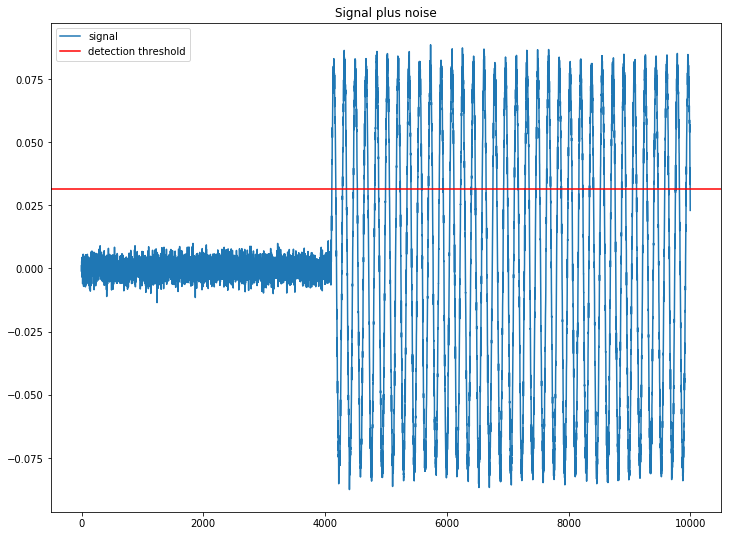

In [53]:
noiseThreshold = -30

signal[:int(noise_only * fs)] = np.zeros(int(noise_only * fs))

signal_and_noise = esarr(signal + noise)

plt.plot(signal_and_noise[40000:50000], label='signal')
plt.axhline(db2amp(noiseThreshold), color='r', label='detection threshold')
plt.title('Signal plus noise')
plt.legend()

A naive aproach would, be to stimate the SNR between the nose and the signal to noise. This is known as a posteri SNR:

In [95]:
snr_aposteri = 10. * np.log10( (instantPower(signal_and_noise) - noise_iP) / noise_iP ) - 10. * np.log10(fs / 2.)

print 'estimated a posteri SNR corrected: {:.2f}dB'.format(snr_aposteri)

estimated a posteri SNR corrected: -19.41dB


However this method is not very precise as it doesn't considers the effect of the noise in the signal.

The recursive algorithm proposed by Ephraim, Y., & Malah works by estimating the SNR frame-wise in the frequency domain with a Minimum Mean Square Error (MMSE) estimator increasing the precission. For each iteration the algorithm returns: 
- the SNR estimation for each frequency bin
- the overall SNR
- an Exponential Mean Average (EMA) of the overall SNR

As the signal is also an stationary process, the EMA SNR estimation should converge to the real SNR that computed from the separated signals:

In [79]:
instant_snrs, ema_snr, snrgram = compute(signal_and_noise, noiseThreshold=noiseThreshold)

print 'estimated EMA SNR corrected: {:.2f}dB'.format(ema_snr)

estimated EMA SNR corrected: -18.42dB


For some applications it can be aso usefull to display the SNRgram. This matrix is also usefull in denoising applications as explained in [2]. However this topic is not covered in this example. (Note that| the empty part at the beginning corresponds with the nose PSD estimation part of the algorithm)

Text(0.5,1.05,u'SNRgram')

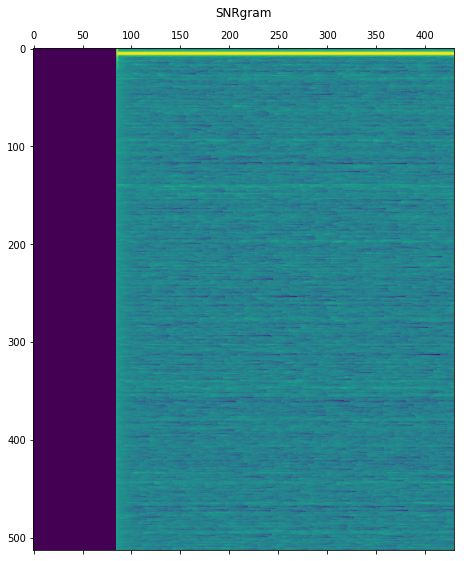

In [78]:
plt.matshow(10 * np.log10(snrgram + eps))
plt.title('SNRgram')

# Bad setting of the threshold

A proper threshold setting is fundamental for this algorithm. Otherwise two problems may occur:
- **threshold higher than the signal:** In this case the whole audio will be considered as noise estimating -inf SNR.

- **threshold lower than noise:** In this case the whole audio will be considered as signal estimating inf SNR

Demostration:

In [83]:
instant_snrs, ema_snr, snrgram = compute(signal_and_noise * .9, noiseThreshold=0)
print 'estimated EMA SNR with too high threshold: {:.2f}dB'.format(ema_snr)

instant_snrs, ema_snr, snrgram = compute(signal_and_noise, noiseThreshold=-90)
print 'estimated EMA SNR with too low threshold: {:.2f}dB'.format(ema_snr)

estimated EMA SNR with too high threshold: -infdB
estimated EMA SNR with too low threshold: infdB


# The parameters
this is an explanation of the most relevant parameters of the algorithm

- **MAAlpha.** This parameter controls the EMA for the averaged SNR. A lower alpha would need less frames to converge but also would be less precise on the estimation.

- **MMSEAlpha.** This parameter controls the weight of the new frame on the Minimum Mean Square Error formula. See [1].

- **NoiseAlpha.** The noise PSD is also estimated with the EMA technique. A lower alpha would need less frames to converge but also would be less precise on the estimation.

- **noiseThreshold.** Threshold to distinguish between just noise or signal plus noise frames

- **useBroadbadNoiseCorrection.** As showed before, the SNR when dealing with withe noise should be corrected as the enery is equally spreaded among all the frequency bins. 